In [80]:
%matplotlib inline

import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np


# Logins EDA

In [61]:
#set the filename and import the data
filename = 'logins.json'
with open(filename) as json_file:
    logins_data = json.load(json_file)


In [68]:
#convert logins data to padnas df, add a rides column to be used for summing later
logins_df = pd.DataFrame(logins_data)
logins_df['rides'] = 1
logins_df['login_time'] = pd.to_datetime(logins_df.login_time)

print(logins_df.info())
print(logins_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 2 columns):
login_time    93142 non-null datetime64[ns]
rides         93142 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 MB
None
           login_time  rides
0 1970-01-01 20:13:18      1
1 1970-01-01 20:16:10      1
2 1970-01-01 20:16:37      1
3 1970-01-01 20:16:36      1
4 1970-01-01 20:26:21      1


In [70]:
#aggregate logins to 15 minute time interval
login_15m = logins_df.resample('15T', on='login_time').sum()
print(login_15m.head())
print(login_15m.tail())

                     rides
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1
                     rides
login_time                
1970-04-13 17:45:00      5
1970-04-13 18:00:00      5
1970-04-13 18:15:00      2
1970-04-13 18:30:00      7
1970-04-13 18:45:00      6


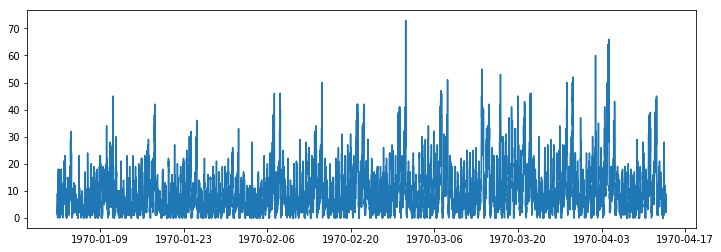

In [71]:
#plot aggregated rides
fig = plt.figure(figsize = (12,4))
plt.plot(login_15m.index, login_15m.rides)
plt.show()

The fluctuations in 15 minute intervals are sometimes pretty extreme. Looking closely, there may be some periodicity that can be teased out. I am going to try to smooth these results by looking at one-hour chunks.

In [72]:
#aggregate data by hour by taking the average of the 15 minute intervals for each hour
login_hr = login_15m.resample('60T').mean()

#add fields for day of week, date, and hour of day
login_hr['day_name'] = login_hr.index.weekday_name
login_hr['date']  = login_hr.index.map(lambda x: x.strftime('%Y-%m-%d'))
login_hr['hour'] = login_hr.index.map(lambda x: x.strftime('%H'))
login_hr.reset_index(inplace=True)

print(login_hr.head())
print(login_hr.tail())

           login_time  rides  day_name        date hour
0 1970-01-01 20:00:00   6.00  Thursday  1970-01-01   20
1 1970-01-01 21:00:00   2.25  Thursday  1970-01-01   21
2 1970-01-01 22:00:00   5.25  Thursday  1970-01-01   22
3 1970-01-01 23:00:00  14.50  Thursday  1970-01-01   23
4 1970-01-02 00:00:00  13.25    Friday  1970-01-02   00
              login_time  rides day_name        date hour
2442 1970-04-13 14:00:00   8.00   Monday  1970-04-13   14
2443 1970-04-13 15:00:00   4.75   Monday  1970-04-13   15
2444 1970-04-13 16:00:00   5.50   Monday  1970-04-13   16
2445 1970-04-13 17:00:00   5.50   Monday  1970-04-13   17
2446 1970-04-13 18:00:00   5.00   Monday  1970-04-13   18


I want to see whether the day of the week has any influence on which hour has the highest average number of riders.

In [73]:
#create a dictionary where each key is a date
#the values are tupes with the hour with the greatest number of riders, the number of rides, and the day of the week
login_dict = {}
for i, v in login_hr.iterrows():
    if v['date'] in login_dict:
        if v['rides'] > login_dict[v['date']][0]:
            login_dict[v['date']] = (v['rides'], v['hour'], v['day_name'])
    else:
        login_dict[v['date']] = (v['rides'], v['hour'], v['day_name'])

#convert that dictionary into a pandas dataframe
column_names = ['rides', 'hour', 'day_name']
df = pd.DataFrame.from_dict(login_dict, orient='index')
df.columns = column_names
print(df.head())


            rides hour  day_name
1970-01-01  14.50   23  Thursday
1970-01-02  17.75   22    Friday
1970-01-03  17.50   02  Saturday
1970-01-04  25.50   02    Sunday
1970-01-05  16.00   11    Monday


In [76]:
#print the hour of each day of the week that most frequently has the highest average ridership
max_hr = df.groupby('day_name')['hour'].agg(lambda x:x.value_counts().index[0])
print(max_hr)

day_name
Friday       22
Monday       11
Saturday     04
Sunday       04
Thursday     22
Tuesday      11
Wednesday    11
Name: hour, dtype: object


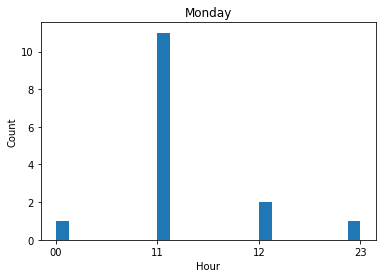

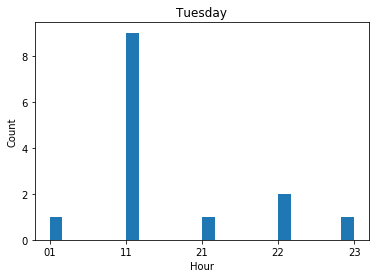

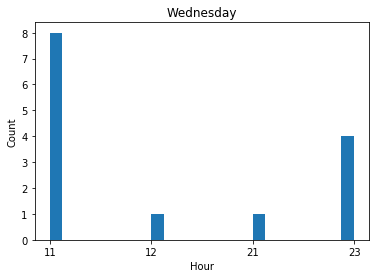

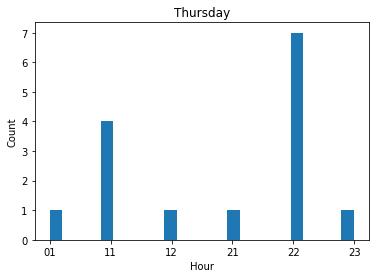

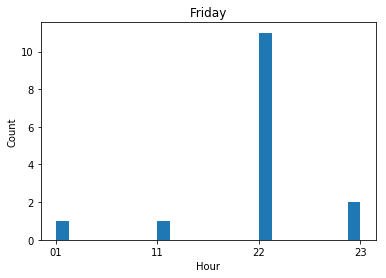

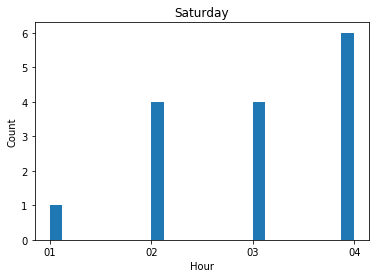

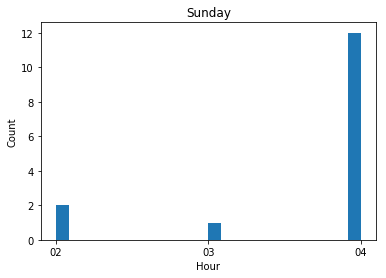

In [81]:
#create a plot for each day, showing which hours tended to have the most average riders
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in days:
    day_df = df[df.day_name == day]
    plt.hist(day_df.hour, bins=24)
    plt.title(day)
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.show()


From the above plots it is evident that demand does depend on the day of the week. Monday, Tuesday, and Wednesday all have the highest demand in the morning in the 11 o'clock hour, although demand for evening is beginnning to increase by Wednesday. On Thursday, there is still some demand at 11 AM but the 11 PM hour is most fequently the hour with the highest demand. On friday the highest demand is at night, 10 PM hour. On Saturday and Sunday the demand is highest in the early hours with 4 AM being the most frequent for both days. It is possible that the early hour boom on Saturdays is a carry over from Friday night ans the 2 AM and 3 AM hours both have high demand as well. I would speculate that the surge at 4 AM on Sundays is also a result of riders calling cars after a long Saturday night.

# Testing Toll Reimbursement

### Key Metric

I would choose the proportion of riders picked up in the driver's NON-primary city to be a good metric of whether toll reimbursement is effective. The city in which a driver picks up >50% of their rides would be considered their "primary" city  and therfore the percentage of rides in the other city would be the metric we are trying to increase. I think this would accurately measure wheter or not a driver is crossing from one city to the next more frequently

### Experimental Design

In order to test this, I would stratify drivers into two groups (primary-Gotham and primary-Metropolis) and then randomly select the same number of drivers from each group to be reimbursed for tolls. To measure the success of this I would then compare the rate of non-primary city pickups for some pre-determined time period prior to the toll reimbursement to the rate of non-primary city pickups after. 

Initially I would keep the data separated by day of the week due to the diurnal nature of the cities. Unless a driver is driving 24 hours a day, they are unlikely perform pickups in both cities, regardless of toll reimbursement, on weekdays due to the lack of rider demand in their non-primary city. 

To test the success of this experiment, I would look at the average change in non-primary city pickups for drivers who received the treatment (toll reimbursement) compared to drivers that received no reimbursement. The null hypothesis would be that the average change in non-primary pickups would be the same for the two groups. The alternative hypothesis would be that the average change is greater for treatement drivers because the number of pickups is expected to INCREASED in for treatment drivers. I would perform a one-sided t-test to test whether the change was significant assuming, of course, that the treatment drivers had a HIGHER non-primary city pickup rate than control drivers. I would probably test each city independently before combining results. It is possible that there is some confounding factor that causes drivers from one city to cross over more frequently than the other.

### Interpreting Results

If the t-test shows no significant increase in cross-city pickups then the results are easy to interpret and I would recommend discontinuing the program.

If the results show a statistically significant increase in cross-city pickups, then the next step would be to weigh the cost of the toll reimbursement with the benefit provided. I would recommend that we look at whether this program somehow increases the total number of rides, or provides some other benefit that increases revenues for the company. It is great if the program accomplishes the goal of getting more cross-city pickups, but if it comes at the expense of the bottom line, then the operations team needs to decide if that lost revenue is worth it.

# Predictive modeling

### Initial Exploration

In [2]:
#read json, convert to Pandas
with open('ultimate_data_challenge.json') as json_file:
    ult_data = json.load(json_file)
    
ult_df = pd.DataFrame(ult_data)

#convert last trip and signup to date time
ult_df['last_trip_date'] = pd.to_datetime(ult_df.last_trip_date)
ult_df['signup_date'] = pd.to_datetime(ult_df.signup_date)

#consider an account active if they've taken a trip in June or later
ult_df['active'] = np.where(ult_df.last_trip_date.dt.month>=6, 1, 0)

#drop records that are incomplete
ult_df.dropna(inplace=True)

print(ult_df.info())
print(ult_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 13 columns):
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
city                      41445 non-null object
last_trip_date            41445 non-null datetime64[ns]
phone                     41445 non-null object
signup_date               41445 non-null datetime64[ns]
surge_pct                 41445 non-null float64
trips_in_first_30_days    41445 non-null int64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
active                    41445 non-null int32
dtypes: bool(1), datetime64[ns](2), float64(6), int32(1), int64(1), object(2)
memory usage: 4.0+ MB
None
   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1   

In [3]:
#inspect the numeric variables
ult_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,active
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,5.460046,4.776446,4.601720,1.073822,8.898709,2.609675,61.254897,0.411027
std,5.145174,0.404606,0.616104,0.198747,18.322061,4.059336,34.813848,0.492026
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,37.500000,0.000000
50%,3.780000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,0.000000
75%,6.490000,5.000000,5.000000,1.070000,11.100000,3.000000,100.000000,1.000000
max,79.690000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000


In [82]:
#print a list of values for number of rides in first 30 days
print(sorted(ult_df.trips_in_first_30_days.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 63, 71, 73, 125]


While 125 rides seems high, it is not outside of the realm of posibility. I am choosing to keep this value in the data.

In [4]:
#inspect unique cities
print(ult_df.city.unique())

["King's Landing" 'Astapor' 'Winterfell']


In [5]:
#inspect unique phone types
print(ult_df.phone.unique())

['iPhone' 'Android']


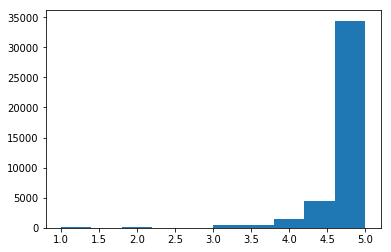

In [7]:
#look at histogram of rider ratings
plt.hist(ult_df.avg_rating_by_driver, bins=10)
plt.show()

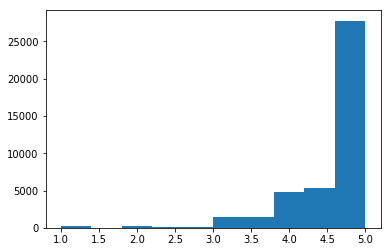

In [8]:
#look at histogram of driver ratings
plt.hist(ult_df.avg_rating_of_driver, bins=10)
plt.show()

Number of active users: 17035
Number of churned users: 24410


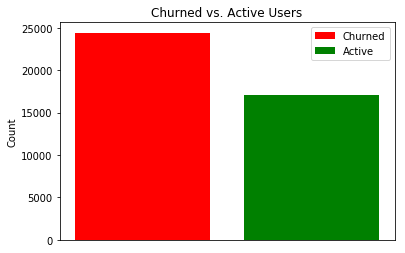

In [6]:
#count the number of riders that have churned and number that are still active
churned = ult_df.active.value_counts()[0]
active = ult_df.active.value_counts()[1]

print('Number of active users:', active)
print('Number of churned users:', churned)

#plot churned vs. active users
fig, ax = plt.subplots()

churn_bar = ax.bar(0, churned, color='r', label='Churned')
act_bar = ax.bar(1, active, color='g', label='Active')

ax.set_xlabel('Group')
ax.set_ylabel('Count')
ax.set_title('Churned vs. Active Users')
ax.get_xaxis().set_visible(False)
ax.legend()

plt.show()

### Predicting Active Users

In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, classification_report, accuracy_score

In [7]:
#use the active column as the labels to predict
labels = ult_df.active

#generate a dataframe of features
#drop last_trip_date and signup_date as these would not be helpful for predicting future riders outside of these date ranges
features = ult_df.drop(['active', 'last_trip_date', 'signup_date'], axis=1)
features = pd.get_dummies(features, drop_first=True)

#split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 24)

#### Logistic Regression

In [83]:
#instantiate a logistic regression model
lr = LogisticRegression()

In [84]:
#fit the model and predict the outcomes of the test set
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

#Print the score and classification report
print('Score:', lr.score(x_test, y_test))
print(classification_report(y_test, y_pred))

Score: 0.7008083001568344
             precision    recall  f1-score   support

          0       0.71      0.82      0.76      4867
          1       0.67      0.53      0.60      3422

avg / total       0.70      0.70      0.69      8289



In [85]:
#print the coefficients for each parameter
cols = list(x_test.columns)
coefs = lr.coef_

for x, y in zip(cols, coefs[0]):
    print(x + ": " + str(round(y, 3)))

avg_dist: -0.037
avg_rating_by_driver: -0.224
avg_rating_of_driver: -0.05
avg_surge: -0.282
surge_pct: 0.004
trips_in_first_30_days: 0.105
ultimate_black_user: 0.921
weekday_pct: -0.0
city_King's Landing: 1.701
city_Winterfell: 0.538
phone_iPhone: 1.092


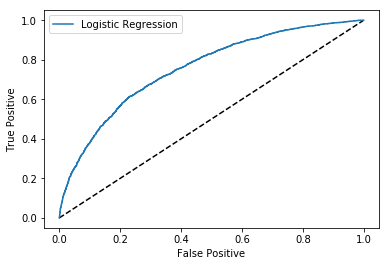

In [86]:
#generate an ROC curve for this model
y_pred_prob = lr.predict_proba(x_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, y_pred_prob)

plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

#### SVM

In [22]:
#create a pipeline to scale data and fit a support vector classifier
steps = [('scaler', StandardScaler()), ('svc', SVC())]
pipeline = Pipeline(steps)

#generate lists of hyperparameters to test using cross-validation
c_options = [1, 10, 100]
gammas = [0.1, 1, 10]
kernels = ['rbf', 'poly']

params = dict(svc__C = c_options, svc__gamma = gammas, svc__kernel=kernels)

In [23]:
#do a grid search cv
cv = GridSearchCV(pipeline, param_grid = params, cv=5)
cv.fit(x_train, y_train)
y_pred = cv.predict(x_test)

#print the best model parameters, accuracy score, and classification report
print(cv.best_params_)
print(cv.score(x_test, y_test))
print(classification_report(y_test, y_pred))

{'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
0.7606466401254675
             precision    recall  f1-score   support

          0       0.77      0.84      0.80      4867
          1       0.74      0.65      0.69      3422

avg / total       0.76      0.76      0.76      8289



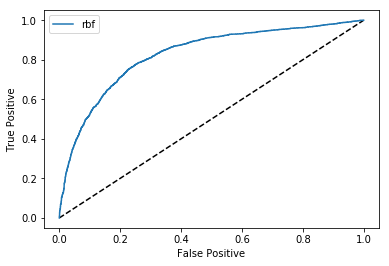

In [24]:
#generate an ROC curve
y_score = cv.decision_function(x_test)
fpr, tpr, thresh = roc_curve(y_test, y_score)

plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr, label=cv.best_params_['svc__kernel'])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

#### Conclusions

I chose to use predict rider retention with both logistic regression as well as support vector machines (SVM). I did attempt this with a linear SVM but the results were no more accurate than the logistic regression. The reason I chose to use an SVM is that, unlike other classifiers such as KNN, you don't need to save all of the underlying data in order to predict the outcome of new data. As long as the support vectors are saved, you can quickly and easily predict whether new riders are going to churn. The SVM, with an rbf kernel, predicted the outcome slightly better than the logistic regression (76% accuracy vs. 70%). While both models predict accurately more than 70% of the time, they could probably be improved by tweaking the model parameters, being more selective about which features to use, or generating new features

Ultimate might be able to leverage these models by using them to predict riders who are may churn and then target them with incentives to continue using their app. While the SVM does predict churn slightly better one downside is that it does not provide a probability of being in one class or the other. Since the SVM is only accurate 76% of the time, it might be of more use to use the logistic regression output and target users that are within a certain threshold of churning. For instance, if the model predicts that a user is 51% likely to be active, Ultimate may still want to target that user with incentives to make up for the uncertainty of the model. The logistic regression provides more flexibility in this situation